In [3]:
%reload_ext autoreload
%autoreload 2

import geopandas
import pandas as pd

from gaza_israel_conflict_analysis.movement_analysis import h3_functions
from gaza_israel_conflict_analysis.movement_analysis import visuals

# Activity Trends in Gaza

This notebook explores the actvity index calculted by Mapbox Movement Data. This analysis is still exploratory and has not been validated yet. 

## Insights

In [4]:
# read shapefiles
GAZA_ADM1 = geopandas.read_file("../../data/gaza_adm1.geojson")

PSE = geopandas.read_file(
    "../../data/boundaries/pse_adm_pamop_20231019_shp/pse_admbnda_adm2_pamop_20231019.shp"
)
GAZA = PSE[PSE["ADM1_EN"] == "Gaza Strip"]

In [5]:
# Resolution for H3 - adjust as needed
resolution = 8  # 0.73 sq. km.

# Apply the function to each geometry in the GeoDataFrame
h3_indexes_series = GAZA_ADM1["geometry"].apply(
    lambda x: h3_functions.geometry_to_h3_indexes(x, resolution)
)

# Creating a new DataFrame to store H3 indexes
gaza_h3 = pd.DataFrame({"h3_index": h3_indexes_series.explode().unique()})

gaza_h3.reset_index(drop=True, inplace=True)

c:\Users\sahit\anaconda3\envs\conflict-analyses\lib\site-packages\geopandas\geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)


In [6]:
gaza_h3["geometry"] = gaza_h3["h3_index"].apply(lambda x: h3_functions.h3_to_polygon(x))
gaza_h3 = geopandas.GeoDataFrame(gaza_h3, geometry="geometry", crs="EPSG:4326")

In [5]:
from plotnine import *

m = gaza_h3.explore(tiles="OpenStreetMap")
m

The Mapbox files have been read from the AWS Server using the below code and converted to CSV files for ease of use

In [35]:
# ddf = dd.read_csv('s3://wbg-mapbox/movement/v4.0.0/PS/quadkey/total/2023/10/*/data/*.csv', sep='|')

In [48]:
import glob

movement = pd.DataFrame(columns=["h3_index", "agg_day_period", "activity_index_total"])

for file in glob.glob("../../data/mapbox/gaza_*"):
    df = pd.read_csv(file)
    df.drop(columns="Unnamed: 0", inplace=True)

    df = h3_functions.process_movement_data(df, gaza_h3, agg_type="h3_index")

    movement = pd.concat([movement, df])

movement = h3_functions.aggregate_movement_to_temporal_aggregation(
    movement, "h3_index", "W-MON"
)

C:\Users\sahit\AppData\Local\Temp\ipykernel_3392\2613332754.py:11: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  movement = pd.concat([movement, df])


In [89]:
import glob

movement_day = pd.DataFrame(
    columns=["h3_index", "agg_day_period", "activity_index_total"]
)

for file in glob.glob("../../data/mapbox/gaza_*"):
    df = pd.read_csv(file)
    df.drop(columns="Unnamed: 0", inplace=True)

    df = h3_functions.process_movement_data(
        df, gaza_h3, agg_type="h3_index", temp_agg_type="D"
    )

    movement_day = pd.concat([movement, df])

In [53]:
import glob

movement_adm = pd.DataFrame(
    columns=["ADM2_EN", "agg_day_period", "activity_index_total"]
)

for file in glob.glob("../../data/mapbox/gaza_*"):
    df = pd.read_csv(file)
    df.drop(columns="Unnamed: 0", inplace=True)

    df = h3_functions.process_movement_data(df, GAZA, agg_type="ADM2_EN")

    movement_adm = pd.concat([movement_adm, df])

movement_adm = h3_functions.aggregate_movement_to_temporal_aggregation(
    movement_adm, "ADM2_EN", "W-MON"
)

C:\Users\sahit\AppData\Local\Temp\ipykernel_3392\1357428343.py:11: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  movement_adm = pd.concat([movement_adm, df])


In [7]:
movement = pd.read_csv("../../data/mapbox/processed/movement_gaza_2023.csv")
movement_adm = pd.read_csv("../../data/mapbox/processed/movement_adm2_gaza_2023.csv")
movement_day = pd.read_csv("../../data/mapbox/processed/movement_h3_day_gaza_2023.csv")

In [69]:
movement_adm = movement_adm.groupby(["ADM2_EN", "agg_day_period"]).sum().reset_index()
movement_adm.to_csv("../../data/mapbox/processed/movement_adm2_gaza_2023.csv")

In [8]:
movement_adm.sort_values(by="agg_day_period", inplace=True)

In [7]:
# Some weeks could've been populated in the previous month's grouping
# movement = movement.groupby(['h3_index', 'agg_day_period']).sum().reset_index()
# movement.to_csv('../../data/mapbox/processed/movement_gaza_2023.csv')
movement.sort_values(by="agg_day_period", inplace=True)

In [8]:
# Some weeks could've been populated in the previous month's grouping
# movement_day = movement.groupby(['h3_index', 'agg_day_period']).sum().reset_index()
# movement_day.to_csv('../../data/mapbox/processed/movement_h3_day_gaza_2023.csv')
movement_day.sort_values(by="agg_day_period", inplace=True)

In [11]:
movement["agg_day_period"] = movement["agg_day_period"].apply(
    lambda x: pd.to_datetime(x)
)

In [12]:
movement_adm.drop(columns="Unnamed: 0", inplace=True)

#### Weekly Activity Trends Before and After the Conflict

In [58]:
from bokeh.plotting import show, output_notebook
import bokeh
from bokeh.core.validation.warnings import EMPTY_LAYOUT, MISSING_RENDERERS
from bokeh.models import Panel, Tabs

output_notebook()

bokeh.core.validation.silence(EMPTY_LAYOUT, True)
bokeh.core.validation.silence(MISSING_RENDERERS, True)

tabs = []

for period in ["Before Conflict", "After Conflict"]:
    if period == "Before Conflict":
        df = movement_adm[movement_adm["agg_day_period"] <= "2023-07-01"]
    else:
        df = movement_adm[movement_adm["agg_day_period"] >= "2023-10-01"]

    tabs.append(
        Panel(
            child=visuals.get_line_chart(
                df,
                "Weekly Activity Trend in Governorates of Gaza",
                "Source: Mapbox Movement",
                subtitle="",
                category="ADM2_EN",
                measure="activity_index_total",
                # color_code=measure_colors["nrFatalities"],
                # category_value=adm2,
            ),
            title=period.title(),
        )
    )

tabs = Tabs(tabs=tabs, sizing_mode="scale_both")
show(tabs, warn_on_missing_glyphs=False)

Loading BokehJS ...

#### Mapping the activity before and after the conflict

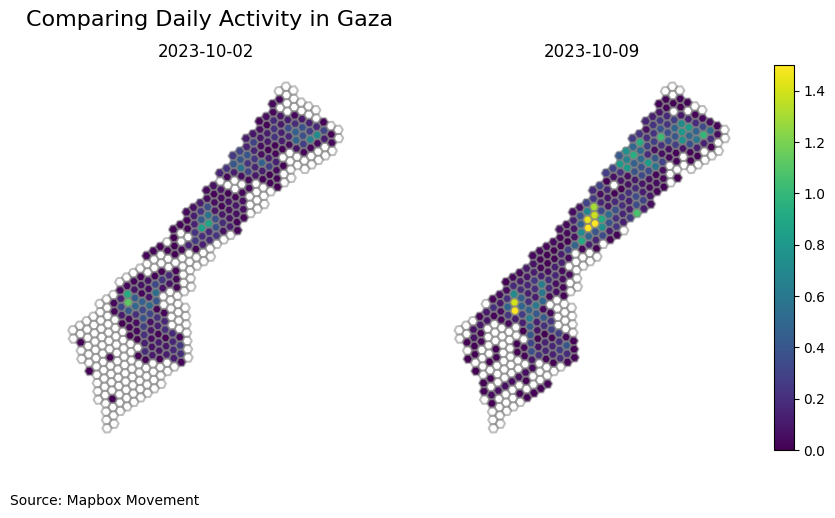

In [48]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
ax = axs.flatten()

for idx, date in enumerate(["2023-10-02", "2023-10-09"]):
    # print(idx)
    gaza_h3.boundary.plot(ax=ax[idx], color="grey", alpha=0.5)
    if idx == 1:
        legend_bool = True
    else:
        legend_bool = False
    gaza_h3.merge(
        movement_day[movement_day["agg_day_period"] == date], on="h3_index"
    ).plot(
        column="activity_index_total", legend=False, ax=ax[idx], vmin=0, vmax=1.5
    )
    ax[idx].axis("off")
    ax[idx].set_title(date)
    #ax[0].text(x=0, y=0, s='Source: Mapbox Movement')

norm = mcolors.Normalize(vmin=0, vmax=1.5)
sm = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
sm.set_array([])  # You have to set an empty array to avoid an error

# Create a colorbar as a continuous legend
cbar = plt.colorbar(sm, ax=ax, orientation='vertical', fraction=0.046, pad=0.04)

fig.text(s='Source: Mapbox Movement', x=0.1, y=0, fontsize=11)
plt.suptitle('Comparing Daily Activity in Gaza', fontsize=16, x=0.3, y=0.99);

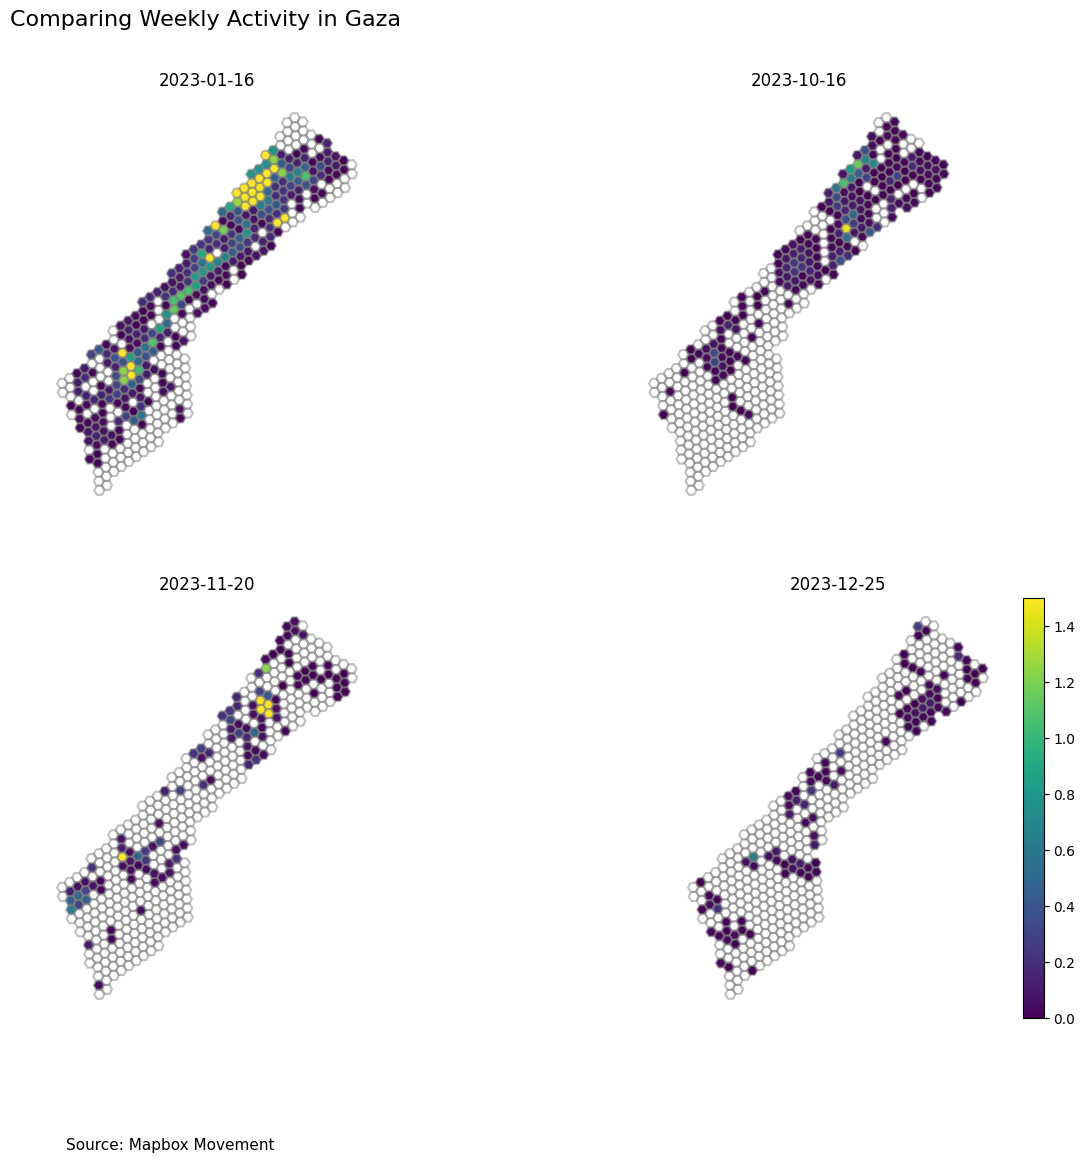

In [51]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 2, figsize=(14, 12))
ax = axs.flatten()

for idx, date in enumerate(
    [
        "2023-01-16",
        "2023-10-16",
        "2023-11-20",
        "2023-12-25",
    ]
):
    gaza_h3.boundary.plot(ax=ax[idx], color="grey", alpha=0.5)
    if idx == 3:
        legend_bool = True
    else:
        legend_bool = False
    gaza_h3.merge(movement[movement["agg_day_period"] == date], on="h3_index").plot(
        column="activity_index_total", legend=False, ax=ax[idx], vmin=0, vmax=1.5
    )
    ax[idx].axis("off")
    ax[idx].set_title(date)

norm = mcolors.Normalize(vmin=0, vmax=1.5)
sm = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
sm.set_array([])  # You have to set an empty array to avoid an error

# Create a colorbar as a continuous legend
cbar = plt.colorbar(sm, ax=ax[3], orientation='vertical', fraction=0.046, pad=0.04)

fig.text(s='Source: Mapbox Movement', x=0.2, y=0, fontsize=11)
plt.suptitle('Comparing Weekly Activity in Gaza', fontsize=16, x=0.3, y=0.95);

#### Interactive Map of Activity in Gaza

<iframe width="100%" height="500px" src="https://studio.foursquare.com/public/fd73dd97-5c35-4768-b8d3-4d148278deee/embed" frameborder="0" allowfullscreen></iframe>